# 1. Carga de datos y librerias a usar.

In [1]:
#Estas lineas corren solo en google colab:
import os.path 
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  if os.path.exists('/content/ChestXRay2017.zip'):
    print("Datos ya descargados")
  else:
    !wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip
    !unzip /content/ChestXRay2017.zip
    !pip install gpustat

Datos ya descargados


In [2]:
import torch
import torchvision
from torchvision.datasets.folder import default_loader

# Intento de usar el train_model de https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
#from torchvision.transforms.functional import convert_image_dtype
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchsummary import summary


In [3]:
# Torchvision transforms compose para carga de datos con transformacion:

degrees = (-20,20)
transformer = torchvision.transforms.Compose([        
    torchvision.transforms.Resize(size = (224,224)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomRotation(degrees),
    torchvision.transforms.ColorJitter(brightness=[1.2, 1.5]),
    torchvision.transforms.ToTensor(), 
    ])

In [4]:
# Usamos el loader por defecto de ImageFolder
# Deja las imagenes con 3 capas
from torchvision.datasets.folder import default_loader
    
import google.colab
import os.path 
root = '/content/chest_xray/train/'
train_dir = '/content/chest_xray/train/'
test_dir = '/content/chest_xray/test/'

data_train1=datasets.DatasetFolder(root = train_dir, loader =  default_loader, transform = transformer, extensions = 'jpeg')
data_test1=datasets.DatasetFolder(root = test_dir, loader = default_loader, transform = transformer, extensions = 'jpeg')

In [5]:
# 3
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torch.utils.data.sampler import RandomSampler, SubsetRandomSampler
from torch.utils.data import DataLoader

# split
train_idx, val_idx = train_test_split(list(range(len(data_train1))),test_size=0.2)
class ReplicarMuestreoDePrueba(torch.utils.data.Sampler):
  def __init__(self,etiquetas_prueba, indices_val, etiquetas_val):
    self.indices_val      = indices_val
    self.prob_pneumonia   = sum(etiquetas_prueba)/len(etiquetas_prueba)
    self.prob_normal      = 1-self.prob_pneumonia
    self.prob_vector      = (np.array(etiquetas_val)==1)*self.prob_pneumonia+(np.array(etiquetas_val)==0)*self.prob_normal
    self.prob_vector = self.prob_vector*(1/sum(self.prob_vector))
  def __iter__(self):
    return iter(np.random.choice(self.indices_val,size=len(self.indices_val),p=self.prob_vector))
  def __len__(self):
    return len(self.indices_val)

etiquetas_prueba = data_test1.targets
etiquetas_val = [data_train1.targets[i] for i in val_idx ]

In [6]:
data_test  = DataLoader(data_test1,sampler=RandomSampler(data_test1))

In [7]:
data_dir = '/content/chest_xray'
bs = 16

dataloaders = {
    'train' : DataLoader(data_train1, 
                         sampler = SubsetRandomSampler(train_idx), 
                         batch_size = bs,
                         num_workers=4
                         ),
    'val' : DataLoader(data_train1,
                       sampler = ReplicarMuestreoDePrueba(etiquetas_prueba,val_idx, etiquetas_val),
                       #sampler = SubsetRandomSampler(val_idx),
                       batch_size = bs,
                       num_workers=4
                       )
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. Red VGG16DWSep.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(2020)

In [9]:
class DWSepConv2d(nn.Module):
    
    def __init__(self,in_channels, out_channels, kernel_size,padding,bias=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels,kernel_size,padding=padding,bias=bias)
        self.conv2 = nn.Conv2d(in_channels, out_channels,kernel_size=1,padding=padding,bias=bias)
    def forward(self,xb):
        xb = F.relu(self.conv1(xb.float()))
        xb = F.relu(self.conv2(xb)) 
        return xb

In [10]:
class VGG16DWSep(nn.Module):
    
    def __init__(self,in_channels):
        super().__init__()
        # bloque 1
        self.conv1 = nn.Conv2d(in_channels,64,kernel_size=3,padding=1,stride=1)
        self.conv2 = nn.Conv2d(64,64,kernel_size=3, padding=1, stride=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2) 
        # bloque 2
        self.dwconv3 = DWSepConv2d(64,128,kernel_size=3,padding=1)
        self.dwconv4 = DWSepConv2d(128,128,kernel_size=3,padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        # bloque 3        
        self.dwconv5 = DWSepConv2d(128,256,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(256)
        # bloque 4
        self.dwconv6 = DWSepConv2d(256,256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)
        # bloque 5
        self.dwconv7 = DWSepConv2d(256,256,kernel_size=3,padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        # bloque 6
        self.dwconv8 = DWSepConv2d(256,512,kernel_size=3,padding=1)
        self.batchnorm3 = nn.BatchNorm2d(512)
        # bloque 7
        self.dwconv9 = DWSepConv2d(512,512,kernel_size=3,padding=1)
        self.batchnorm4 = nn.BatchNorm2d(512)
        # bloque 8
        self.dwconv10 = DWSepConv2d(512,512,kernel_size=3,padding=1)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2,stride=2)
        # bloque o1
        self.flatten1 = nn.Flatten()
        self.lin1 = nn.Linear(184832,1024)
        self.drop1 = nn.Dropout(.7)
        # bloque o2
        self.lin2 = nn.Linear(1024,512)
        self.drop2 = nn.Dropout(.5)
        self.lin3 = nn.Linear(512,2)
    
    def forward(self,xb):
      # bloque 1
      xb = xb.view(-1, 3, 224, 224)
      xb = F.relu(self.conv1(xb))
      xb = F.relu(self.conv2(xb))
      xb = self.maxpool1(xb)
      # bloque 2
      xb = F.relu(self.dwconv3(xb))
      xb = F.relu(self.dwconv4(xb))
      xb = self.maxpool2(xb)
      # bloque 3
      xb = F.relu(self.dwconv5(xb))
      xb = F.relu(self.batchnorm1(xb))
      # bloque 4
      xb = F.relu(self.dwconv6(xb))
      xb = F.relu(self.batchnorm2(xb))
      # bloque 5
      xb = F.relu(self.dwconv7(xb))
      xb = self.maxpool3(xb)
      # bloque 6
      xb = F.relu(self.dwconv8(xb))
      xb = F.relu(self.batchnorm3(xb))
      # bloque 7
      xb = F.relu(self.dwconv9(xb))
      xb = F.relu(self.batchnorm4(xb))
      # bloque 8
      xb = F.relu(self.dwconv10(xb))
      xb = self.maxpool4(xb)
      #print(xb.shape)
      # bloque o1
      xb = self.flatten1(xb)
      xb = F.relu(self.lin1(xb))
      xb = self.drop1(xb)
      # bloque o2
      xb = F.relu(self.lin2(xb))
      xb = self.drop2(xb)
      xb = F.relu(self.lin3(xb))
      return xb.view(-1, xb.size(1))

## Importar red VGG16 ya entrenada para transferir pesos:

In [11]:
# Descargamos la red vgg16
try: 
  summary(vgg16.cuda(),(3,224,244))
except:
  vgg16 = torchvision.models.vgg16(pretrained=True, progress=True)
  summary(vgg16.cuda(),(3,224,244))

# Congelamos los pesos de la red VGG16:
for param in vgg16.parameters():
  param.requires_grad = False

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 244]           1,792
              ReLU-2         [-1, 64, 224, 244]               0
            Conv2d-3         [-1, 64, 224, 244]          36,928
              ReLU-4         [-1, 64, 224, 244]               0
         MaxPool2d-5         [-1, 64, 112, 122]               0
            Conv2d-6        [-1, 128, 112, 122]          73,856
              ReLU-7        [-1, 128, 112, 122]               0
            Conv2d-8        [-1, 128, 112, 122]         147,584
              ReLU-9        [-1, 128, 112, 122]               0
        MaxPool2d-10          [-1, 128, 56, 61]               0
           Conv2d-11          [-1, 256, 56, 61]         295,168
             ReLU-12          [-1, 256, 56, 61]               0
           Conv2d-13          [-1, 256, 56, 61]         590,080
             ReLU-14          [-1, 256,

In [12]:
# Se quiere la capa 0 y la 2, que son las dos primeras convolucionales:
pesos_dict = {
    'conv1' : vgg16.features[0],
    'conv2' : vgg16.features[2]
}

In [13]:
# Instanciamos una reg VGG16DWSep:
model = VGG16DWSep(in_channels = 3)

In [14]:
# Transferencia de pesos:
model.conv1.weight = pesos_dict['conv1'].weight
model.conv2.weight = pesos_dict['conv2'].weight

In [15]:
# Congelamos los pesos transferidos en la red instanciada:
model.conv1.requires_grad_ = False
model.conv2.requires_grad_ = False

In [16]:
summary(model.cuda(), (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]          36,928
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          36,928
            Conv2d-5        [-1, 128, 114, 114]           8,320
       DWSepConv2d-6        [-1, 128, 114, 114]               0
            Conv2d-7        [-1, 128, 114, 114]         147,584
            Conv2d-8        [-1, 128, 116, 116]          16,512
       DWSepConv2d-9        [-1, 128, 116, 116]               0
        MaxPool2d-10          [-1, 128, 58, 58]               0
           Conv2d-11          [-1, 128, 58, 58]         147,584
           Conv2d-12          [-1, 256, 60, 60]          33,024
      DWSepConv2d-13          [-1, 256, 60, 60]               0
      BatchNorm2d-14          [-1, 256,

## Heuristica EarlyStopping:

In [17]:
# Clase EarlyStopping
# Se requiere la libreria numpy!!
import numpy  as np
class EarlyStopping():
  '''
  Regularization heuristic:

  '''
  def __init__(self, modo='min', paciencia=5, porcentaje:bool = False, tol=0):
    '''
    Arguments:
    ---------
    modo: 'min' o 'max'. Si se debe minimizar o maximizar la metrica objetivo
    paciancia: Cantidad de epocas en la que la metrica puede empeorar
    porcentaje: si la diferencia es relativa (true) o absoluta
    tol: diferencia minima que debe existir con respecto la mejor metrica ya
        observada  para considerar si existe un empeoramiento del desempeno
    '''
    self.modo = modo
    self.paciencia  = paciencia
    self.porcentaje = porcentaje
    self.best = np.Inf if self.modo == 'min' else -np.Inf
    self.contador = 0
    self.tol = tol

  
  def __compareMin(self, metrica_validacion):
    if self.porcentaje:      
      # Si la dif relativa es mayor a la tolerada: actualizar contador:
      if metrica_validacion < (1-self.tol)*self.best:
        self.contador = 0
        self.best = metrica_validacion
        return True
      else:
        self.contador +=1
        return False
    else:
      if metrica_validacion < self.best - self.tol:
        self.best = metrica_validacion
        self.contador = 0
        return True
      else:
        self.contador += 1
        return False
    
  def __compareMax(self, metrica_validacion):
    if self.porcentaje:
        # Si la dif relativa es mayor a la tolerada: actualizar contador:
      if metrica_validacion > (1+self.tol)*self.best:
        self.contador = 0
        self.best = metrica_validacion
        return True
      else:
        self.contador +=1
        return False
    else:
      if metrica_validacion > self.best + self.tol:
        self.best = metrica_validacion
        self.contador = 0
        return True
      else:
        self.contador += 1
        return False        

  def __mejor(self, metrica_validacion):
    '''
    Compara @metrica_validacion con la mejor ya observada segun las 
    especificaciones de porcentaje y modo. 
    '''
    if self.modo == 'min':
      # Comparar segun el modo y porcentaje:
      if self.__compareMin(metrica_validacion):
        return True
      else:
        return False
    else:
      # Comparar segun el modo y porcentaje:
      if self.__compareMax(metrica_validacion):
        return True
      else:
        return False

  #@classmethod
  def deberia_parar(self, metrica_validacion):
    if not self.__mejor(metrica_validacion) and self.contador >= self.paciencia:
      return True
    else:
      return False


## Train model: 
Basado en metodo fit implementado en los notebooks de catedra:

In [18]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [19]:
import numpy as np 

def register(res_list):
    '''Obtiene la perdida promedio y su desviacion estandar en batches.'''
    
    losses, nums = zip(*res_list)
    
    N = np.sum(nums)
    loss_mean = np.sum(np.multiply(losses, nums))/N
    loss_std = np.sqrt(np.sum(np.multiply((losses-loss_mean)**2, nums))/(N-1))
    
    return loss_mean, loss_std

In [20]:
def accuracy(y_hat_b,yb):
    
    preds = torch.argmax(torch.softmax(y_hat_b,dim = 1),dim=1)
    counts = (preds == yb)*1.0
    
    return torch.mean(counts)

In [21]:
import pandas as pd

def train_model(model, loss_func, opt, metric = None, modo = 'min', paciencia = 5, num_epochs=20, print_leap = 1):
  since = time.time()
  es = EarlyStopping(modo = 'max', paciencia=paciencia)
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  if metric is None:
    metric = accuracy

  learning_data_loss = pd.DataFrame(
  columns=['epoch', 'train_mean', 'train_std', 'val_mean', 'val_std'])
  learning_data_acc = pd.DataFrame(
  columns=['epoch', 'train_mean', 'train_std', 'val_mean', 'val_std'])

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    train_res_loss = []
    train_res_acc = []
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode

        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # Para entrenar se usa la funcion de perdida
          loss_batch(model, loss_func, inputs, labels, opt)

          # Para almacenar se puede usar una metrica
          train_res_loss.append(loss_batch(model, loss_func, inputs, labels))
          train_res_acc.append(loss_batch(model, metric, inputs, labels))
      else:
        model.eval()   # Set model to evaluate mode
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          with torch.no_grad():
            val_res_loss = [
                loss_batch(model, loss_func, inputs, labels) 
            ]
            val_res_acc = [
                  loss_batch(model, metric, inputs, labels)          
            ]
    # Register loss func
    val_loss, val_loss_std = register(val_res_loss)
    train_loss, train_loss_std = register(train_res_loss)
    # Register acc
    val_acc, val_acc_std = register(val_res_acc)
    train_acc, train_acc_std = register(train_res_acc)

    if epoch % print_leap == 0:
      print('Epoca:', epoch, '- val loss:', val_loss, '- train loss:', train_loss)
      print('Epoca:', epoch, '- val acc:', val_acc, '- train acc:', train_acc)
      print('-'*20)

    learning_data_loss = learning_data_loss.append(
                    {
                    'epoch': epoch,
                    'train_mean': train_loss,
                    'train_std': train_loss_std,
                    'val_mean': val_loss,
                    'val_std': val_loss_std
                    },
                    ignore_index=True)
    
    learning_data_acc = learning_data_acc.append(
                    {
                    'epoch': epoch,
                    'train_mean': train_acc,
                    'train_std': train_acc_std,
                    'val_mean': val_acc,
                    'val_std': val_acc_std
                    },
                    ignore_index=True)

     
    if phase == 'val' and val_acc > best_acc:
      best_acc = val_acc
      best_model_wts = copy.deepcopy(model.state_dict())

    #if es.deberia_parar(val_acc):
     # break
    #else:
     # continue
    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
  time_elapsed // 60, time_elapsed % 60))

  return model, best_model_wts,learning_data_loss, learning_data_acc

In [22]:
model_ft = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4, weight_decay=1e-5)

In [23]:
model_ft, best_model,train_loss, train_acc = train_model(model_ft, criterion, optimizer_ft,  paciencia = 5,
                       num_epochs=20)

Epoch 0/19
----------
Epoca: 0 - val loss: 0.6761283278465271 - train loss: 0.3128682988127215
Epoca: 0 - val acc: 0.5714285969734192 - train acc: 0.8083632019258314
--------------------

Epoch 1/19
----------
Epoca: 1 - val loss: 0.06750436872243881 - train loss: 0.1762985646083791
Epoca: 1 - val acc: 1.0 - train acc: 0.927120669056153
--------------------

Epoch 2/19
----------
Epoca: 2 - val loss: 0.24649794399738312 - train loss: 0.15155562593589406
Epoca: 2 - val acc: 0.8571429252624512 - train acc: 0.9436081242675279
--------------------

Epoch 3/19
----------
Epoca: 3 - val loss: 0.18534669280052185 - train loss: 0.14427473590561282
Epoca: 3 - val acc: 0.8571429252624512 - train acc: 0.9493428912783751
--------------------

Epoch 4/19
----------
Epoca: 4 - val loss: 0.021527323871850967 - train loss: 0.13585897249702628
Epoca: 4 - val acc: 1.0 - train acc: 0.9510155316749354
--------------------

Epoch 5/19
----------
Epoca: 5 - val loss: 0.02414468303322792 - train loss: 0.1247

In [24]:
import matplotlib.pyplot as plt

def show_learning_curves(learning_data, y_name = 'Metrica',leaps = 1):
    '''Genera curvas de aprendizaje dado data dataframe resultado de fit().'''
    
    fig, ax = plt.subplots(figsize=[10, 7])
    ax.grid()


    epcs = learning_data['epoch'][::leaps]
    val_loss_lower = (learning_data['val_mean'] -
                      learning_data['val_std'])[::leaps]

    val_loss_upper = (learning_data['val_mean'] +
                      learning_data['val_std'])[::leaps]

    train_loss_lower = (learning_data['train_mean'] -
                        learning_data['train_std'])[::leaps]
    train_loss_upper = (learning_data['train_mean'] +
                        learning_data['train_std'])[::leaps]

    ax.plot(epcs,
            learning_data['val_mean'][::leaps],
            'o--',
            color="g",
            label="Validation")

    ax.fill_between(epcs, val_loss_lower, val_loss_upper, alpha=0.1, color='g')

    ax.plot(epcs,
            learning_data['train_mean'][::leaps],
            'o--',
            color="r",
            label="Train")

    ax.fill_between(epcs, train_loss_lower, train_loss_upper, alpha=0.1, color='r')

    ax.set_title('Curva de Aprendizaje', fontsize=25)
    ax.set_xlabel('Epocas', fontsize=15)
    ax.set_ylabel(y_name, fontsize=15)
    ax.legend()

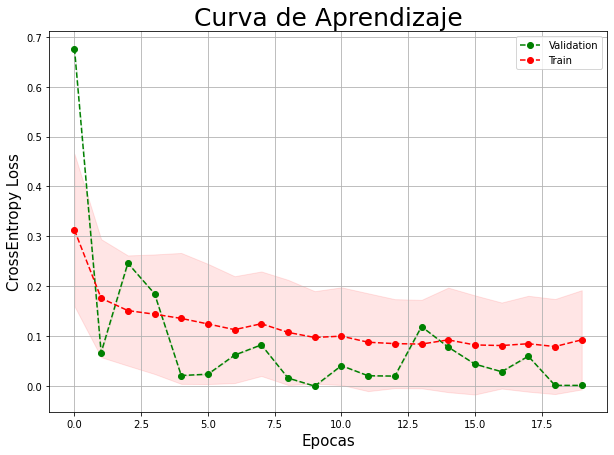

In [25]:
show_learning_curves(train_loss,'CrossEntropy Loss')

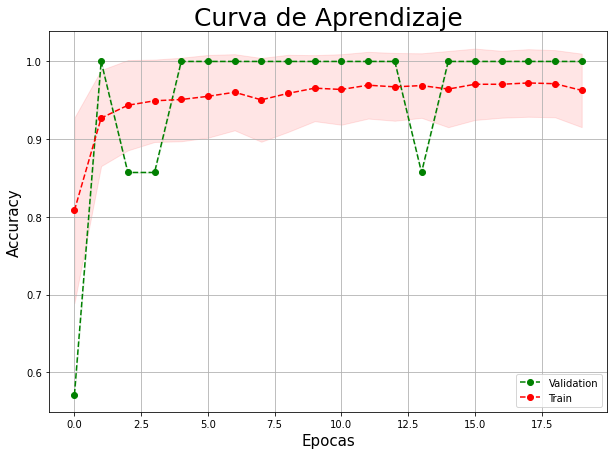

In [26]:
show_learning_curves(train_acc, 'Accuracy')

Testeo de la red:

In [27]:
model.to(device)

VGG16DWSep(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dwconv3): DWSepConv2d(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (dwconv4): DWSepConv2d(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dwconv5): DWSepConv2d(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
  )
  (batchnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

In [28]:
def test_model(model, data_test_loader):
  model.eval()
  y_pred = []
  y_true = []
  for X, y in data_test:
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
      preds = torch.argmax(torch.softmax(model(X),dim = 1),dim=1)
      y_pred.append(preds)
      y_true.append(y)
  y_true = [int(y.to('cpu')) for y in y_true]
  y_pred = [int(y.to('cpu')) for y in y_pred]
  return y_pred, y_true

In [29]:
y_pred, y_test = test_model(model, data_test)

In [34]:
from sklearn.metrics import f1_score, accuracy_score
print('f1 score on test set: ', f1_score(y_test, y_pred))
print('Accuracy on test set: ', accuracy_score(y_test, y_pred))

f1 score on test set:  0.8366013071895426
Accuracy on test set:  0.7596153846153846


In [36]:
!gpustat -p

bbd1f04cf614             Sat Jul 18 00:18:13 2020  418.67
[0] Tesla P100-PCIE-16GB | 42'C,   0 % | 12419 / 16280 MB |


In [38]:
# Creacion y guardado de archivo hdf:
import h5py
hf = h5py.File('model.h5', 'w')

In [39]:
path = '/content/model.h5'
torch.save(model.state_dict(), path)